# TEC detrender for random days

The goal of this progrma is to get detrended time series TEC curves using the method
Described by Pradipta et al. 2015. We expect that the resulting detrended TEC data show
ionospheric perturbations in our dataset.

We found important perturbations in stations BOAV, KOUG and KOUR, but we also found that these stations were located in a position where the sunset occurred almost at the same time that the meteor fell. So I have the doubt if the detected perturbations are caused by the meteor itself or the solar terminator. To solve the doubt, we will detrend the GPS data of the same station (KOUG for beginning) for previous days (where clearly a meteor didn't fall, but soon enough for the solar terminator position don't change so much) and see if the same TIDs are detected. If we find nothing, we may be pretty sure that the TIDs are due to the meteor fall, but in the opposite case we may give up all the work I've done by two years.

In [87]:
import numpy as np
from astropy.table import Table
import argparse
import glob 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter as savitsky
from scipy.stats import mode

## Useful functions

In [88]:
def next_contact_point(x, y, x0, y0):
    """
    Estimate the next contact point into the Barrell roll curve (BRC)
    inputs:
    x: scaled time.
    y: scaled vTEC
    x0: x pivot point
    y0: y pivot point
    output:
    (xf, yf): coordinates of the next contact point
    """
	# Define region of interest
    R0 = 1 # Radius of the barrell roll. Unitary radius works pretty well
    ROI = (x > x0) & (x < x0 + 2*R0)
	# Delta_x and delta_y are the separation between the elements which belong to the ROI and (x0, y0)
    delta_x = x[ROI]-x0
    delta_y = y[ROI]-y0

    try:
	      # calculating important angles
        theta = np.arctan2(delta_y, delta_x)
        cos_alpha = np.sqrt(delta_x**2 + delta_y**2)/(2*R0) 
        delta = np.arcsin(cos_alpha) - theta
	      # Selecting the Next Contact Point (NCP)
        NCP = delta == min(delta) # The next contact point has the smallest angular distance delta
        xf, yf = x0+delta_x[NCP][0], y0+delta_y[NCP][0]
    except ValueError: # this happens because ROI is empty
        xf, yf = x[~ROI & (x>x0)][0], y[~ROI & (x>x0)][0] #The element we will use as next contact point
								# is the first outside the ROI and greater than x0
    return xf, yf

In [89]:
def free_dep_signal(brc_x, brc_y, x, y):
    """
    Create the free depletion signal.
    Inputs:
    (brc_x, brc_y): Barrel roll curve coordinates
    (x, y): TEC curve 
    output:
    (xf, yf): free depletion signal
    """
    delta_1, delta_2 = 1, 3
    BRC_plus = brc_y + delta_1
    BRC_minus = brc_y - delta_2
    int_bplus = interp1d(brc_x, BRC_plus)
    int_bminus = interp1d(brc_x, BRC_minus)
    mask = (y < int_bplus(x)) & (y> int_bminus(x))
    xf, yf = x[mask], y[mask]
    return xf, yf

In [90]:
def get_window_size(x):
    """
    Get window size for the Savitzky-Golay filter. Must be an *odd* integer.
    This module basically substracts 1 if x is an even number and keeps the number if x is odd
    the output number is integer
    """
    return int(2*np.ceil(x/2.)-1)

In [91]:
def split_PRN(t, TEC):
    """
    Split a discontinuos PRN into pieces and return the biggest ones
    inputs:
    t, TEC: arrays to be split. t --> time , TEC --> vTEC
    outputs:
    output_t, output_TEC --> 2D arrays which contain the fragmented curve
    """

    index_discontinuity =[]
    gradient_t = np.gradient(t)
    for i, dt in enumerate(gradient_t):
        if dt > 0.01: # 0.01 is like 10 times the regular GPS frequency
            index_discontinuity.append(i) # collect the indices where time gradient is big enough
        split_t = np.split(t, index_discontinuity)
        split_TEC = np.split(TEC, index_discontinuity)
        output_t = []
        output_TEC =[]
        for s, tec in zip(split_t, split_TEC):
            if len(s) > 20: #if the subarray contain too few elements will be discarded
                output_t.append(s)
                output_TEC.append(tec)
        return output_t, output_TEC

## Load data for KOUG station, one of the stations near the solar terminator

In [92]:
f = open("./data/2019-06-22/set5/previous/koug169-2019-06-18.Cmn", "r")

In [93]:
for i in range(3):
    f.readline()
raw_data = f.readlines()

In [94]:
data = Table.read(raw_data, format="ascii")
data.keys()

['MJdatet', 'Time', 'PRN', 'Az', 'Ele', 'Lat', 'Lon', 'Stec', 'Vtec', 'S4']

## Extract relevant information from files

In [95]:
starttime = 21+25/60.+48./3600
fh = 200
fl = 150
time = data["Time"]
PRN = data["PRN"]
TEC = data["Stec"]
t_corrector = time < 0
time[t_corrector] = time[t_corrector] + 24.0
tau_0, zeta_0 = 2.0, 40.0
prn_array = np.unique(PRN)
time_mask = (time < starttime +fh/60.) & (time > starttime -fl/60.)

## Create arrays for final information

In [96]:
final_time = []
final_PRN = []
final_TEC = []

## Start loop over PRNs

In [97]:
for p in prn_array:
    PRN_mask = PRN == p
    filtered_time = time[PRN_mask & time_mask]
    filtered_TEC = TEC[PRN_mask & time_mask]
    if (len(filtered_time)<20):
        continue
# Split the signal into fragments
    S_time, S_TEC = split_PRN(filtered_time, filtered_TEC)
    for s, tec in zip(S_time, S_TEC):
        X, Y = s/tau_0, tec/zeta_0
        x_0, y_0 = X[0], Y[0]
        BRC_x, BRC_y = [x_0], [y_0]
        try:
            while(x_0 < X[-1]):
                xn, yn = next_contact_point(X, Y, x_0, y_0)
                BRC_x.append(xn)
                BRC_y.append(yn)
                x_0, y_0 = xn, yn
        except IndexError:
            print("Skip to next PRN")
            continue
# Return to the time-TEC space
        brc_t, brc_vt = np.array(BRC_x)*tau_0, np.array(BRC_y)*zeta_0
        fdp_x, fdp_y = free_dep_signal(brc_t, brc_vt, s, tec)  
# Get trend
        y_trend = savitsky(tec, window_length=get_window_size(0.25*len(tec)), polyorder=3)
        residuals = np.sum((y_trend-tec)**2)/len(tec)
# Detrend signal
        det_signal = tec - y_trend
        mean = np.mean(det_signal)
        for ft, d in zip(s, det_signal): # Fill output lists
            final_TEC.append(d)
            final_time.append(ft)          
            final_PRN.append(p)
output_table = Table([final_time, final_PRN, final_TEC], names=("Time", "PRN", "sTEC"))
output_table.write("KOUG-2019-06-18.csv", format="csv", overwrite=True)

/tmp/ipykernel_3427/3093323418.py:23: RuntimeWarning: invalid value encountered in arcsin
  delta = np.arcsin(cos_alpha) - theta


# Second part: plot time series from detrended data

In [98]:
import pandas as pd
import seaborn as sns

In [99]:
csv_data = pd.read_csv("KOUG-2019-06-18.csv")
csv_data.head(15)

,Time,PRN,sTEC
0,18.933333,2,0.302290
1,18.941667,2,0.252936
2,18.950000,2,0.293862
3,18.958333,2,0.295071
4,18.966667,2,0.266568
5,18.975000,2,0.158357
6,18.983333,2,0.160443
7,18.991667,2,0.142829
8,19.000000,2,0.185520
9,19.008333,2,0.158519


In [100]:
prn_list = np.unique(csv_data["PRN"])
prn_list

array([ 2,  3,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 17, 19, 22, 23, 24,
       28, 29, 30])

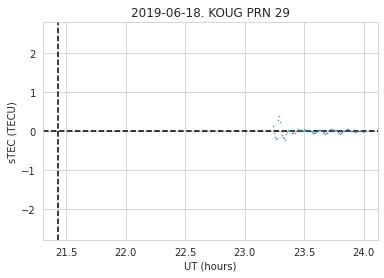

In [109]:
sns.set_style("whitegrid")
prn_mask = csv_data["PRN"]==29
csv_time = csv_data["Time"][prn_mask]
csv_TEC = csv_data["sTEC"][prn_mask]
plt.axvline(starttime, ls="--", c="k")
plt.axhline(0, ls="--", c="k")
plt.plot(csv_time, csv_TEC, ".", ms=0.8)
plt.xlabel("UT (hours)")
plt.ylabel("sTEC (TECU)")
plt.title("2019-06-18. KOUG PRN 29")
plt.ylim(-2.8, 2.8)
plt.savefig("KOUG_2019-06-18_PRN29.pdf")

As a preliminar conclusion I found out that solar terminator does perturb the ionosphere, but this effect is weak in comparison with the meteor passage. Neverthless, studying previous days time series may help us to discriminate between real detections from "crappy detections" (wave-like features that are just noise).